###### 22.11.04.(금)_B1
# 종합실습2_후판공장 Scale불량 발생 분석 보고

## 목차
- 1. 배경 및 목적
- 2. 전처리
- 3. 시각화
- 4. 결론

#  1. 배경 및 목적 

고객사 공장에서 'Scale 불량 증가 이슈'가 발생한 상황이다. 따라서 수집한 데이터를 분석하여 빠르고 정확한 TroubleShooting을 진행하고자 합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib as mpl
%matplotlib inline 
import matplotlib.font_manager as fm
from sklearn import datasets

from statsmodels.graphics.tsaplots import plot_predict
from sklearn.tree import export_graphviz 
import graphviz

import scipy.stats
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neural_network import MLPClassifier
from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

font_fname = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'
fontprop = fm.FontProperties(fname=font_fname, size=18).get_name()
matplotlib.rc('font',family= fontprop)
matplotlib.rc('axes',unicode_minus=False)

from statsmodels.api import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import mean_absolute_error
from skimage.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 철강 후판의 표면 결함으로는 스케일, 스켑, 균열. 이물홈이 존재 
 - 압연공정 회전하는 2개의 롤 사이에 끼우고 롤의 간격을 점차 좁히면서 연속적인 힘을 가하여 늘리거나 얇게 만드는 과정

 
STEEL_KIND:강종

 ### 후판과정에서 스케일에 영향을 주는 요인이 되지 않을까 생각이됨 두께와 폭 길이에 따라 힘이 가해지는 영향이 다를것라고 생각이됨 일정한 폭,두께,길이가 관건이라고 생각이됨
 - PT_THICK:Plate 두께
 - PT_WIDTH:Plate 폭   
 - PT_LENGTH:Plate 길이

### 압연의 적정 온도의 경우 일반적으로 1000 ~ 1100도 사이. 제강 연주에서 나와 압연까지 이송을 하면, 온도가 떨어지면서 740~800도 정도에서 압연에 진입하기 때문에 부적합한 온도로 인해 가열공정이 필요됨. 즉, 가열로에 넣어서 적정 압연 온도를 맞춘 후 작업하는 것.  
 - FUR_HZ_TEMP:가열로 가열대 온도(oC)
 - FUR_HZ_TIME:가열로 가열대 시간(분)
 - FUR_SZ_TEMP:가열로 균열대 온도(oC)
 - FUR_SZ_TIME:가열로 균열대 시간(분)
 - FUR_EXTEMP:추출온도(oC)
 - ROLLING_TEMP_T5:압연온도(oC)

# 철강재 scale을 처리하는 유일한 방법은 오로지 닦고 또 닦는 방법밖에 없다. 가열로에서 나온 후 scale을 떼어내는 과정을 Descaling이라고 한다.
 - ROLLING_DESCALING:압연 중 Descaling 횟수

 ## 즉 압연의 모든 과정에서 일어나는 가열대의 적절한 온도, 시간/ 균열대의 적절한 온도, 시간, / 압연 온도/ 추출온도 등 압연공정 과정에 발생되는 모든 과정이 scale에 영향을 준다고 판단이됨 / 압연공정 과정에 모든 설명변수에 중점을 두어 분석을 하고자 한다.

#  2. 전처리(1) 

## 데이터 구성하기

In [4]:
df_raw = pd.read_csv("~/바탕화면/2. Big Data 분석/SCALE불량.csv", encoding='euc-kr')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2021-08-01:08:00:01,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2021-08-01:08:07:11,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2021-08-01:08:14:21,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조
3,PB562777,2021-08-01:08:21:31,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885,적용,8,3조
4,PB562778,2021-08-01:08:28:41,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873,적용,8,1조


In [5]:
def fun_data_layout(v_data):
    print("Data 구조:", v_data.shape)
    print()
    print("변수 : ", v_data.columns)
    print()

In [6]:
# Data 구조 확인
fun_data_layout(df_raw)

Data 구조: (720, 21)

변수 :  Index(['PLATE_NO', 'ROLLING_DATE', 'SCALE', 'SPEC', 'STEEL_KIND', 'PT_THICK',
       'PT_WIDTH', 'PT_LENGTH', 'PT_WEIGHT', 'FUR_NO', 'FUR_NO_ROW',
       'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME',
       'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'WORK_GR'],
      dtype='object')



In [7]:
df_raw.info() #칼럼 목록 별 Dtype을 확인합니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THICK           720 non-null    float64
 6   PT_WIDTH           720 non-null    int64  
 7   PT_LENGTH          720 non-null    int64  
 8   PT_WEIGHT          720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    object 
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

In [8]:
df_raw.describe()

,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1155.338889,88.204167,1149.666667,75.330556,300.563889,1139.570833,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,20.866398,36.248696,17.571788,26.086390,45.390303,17.857121,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1102.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1122.750000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1144.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,1171.000000,101.000000,1164.000000,85.250000,342.000000,1154.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,1206.000000,251.000000,1185.000000,194.000000,398.000000,1175.000000,1078.000000,10.000000


In [9]:
print(df_raw.isnull().sum()) # 결측치 조회 결과 결측치는 발견되지 않았다.

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THICK             0
PT_WIDTH             0
PT_LENGTH            0
PT_WEIGHT            0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64


### 문자형 목표변수 -> 숫자형으로 변환

In [10]:
df_raw = df_raw.drop(['PLATE_NO', 'ROLLING_DATE'] ,axis=1) # PLATE_NO는 ID이기 때문에 제외, ROLLING_DATE 제외변수
# 범주형 변수들 변환
df_raw['SCALE'] = le.fit_transform(df_raw['SCALE'])
df_raw['SPEC'] = le.fit_transform(df_raw['SPEC'])
df_raw['STEEL_KIND'] = le.fit_transform(df_raw['STEEL_KIND'])
df_raw['FUR_NO'] = le.fit_transform(df_raw['FUR_NO'])
df_raw['FUR_NO_ROW'] = le.fit_transform(df_raw['FUR_NO_ROW'])
df_raw['HSB'] = le.fit_transform(df_raw['HSB'])
df_raw['WORK_GR'] = le.fit_transform(df_raw['WORK_GR'])

- 편리한 데이터 시각화를 위해 양품을 1로, 불량을 0으로 수치화함

In [11]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,1,7,4,32.25,3707,15109,14180,0,0,1144,116,1133,59,282,1125,934,1,8,1
1,1,7,4,32.25,3707,15109,14180,0,1,1144,122,1135,53,283,1120,937,1,8,1
2,1,62,8,33.27,3619,19181,18130,1,0,1129,116,1121,55,282,1106,889,1,8,2
3,1,62,8,33.27,3619,19181,18130,1,1,1152,125,1127,68,316,1113,885,1,8,2
4,1,17,8,38.33,3098,13334,12430,2,0,1140,134,1128,48,314,1118,873,1,8,0


## 이상치 확인

### boxplot으로 모든 칼럼을 확인

<AxesSubplot:>

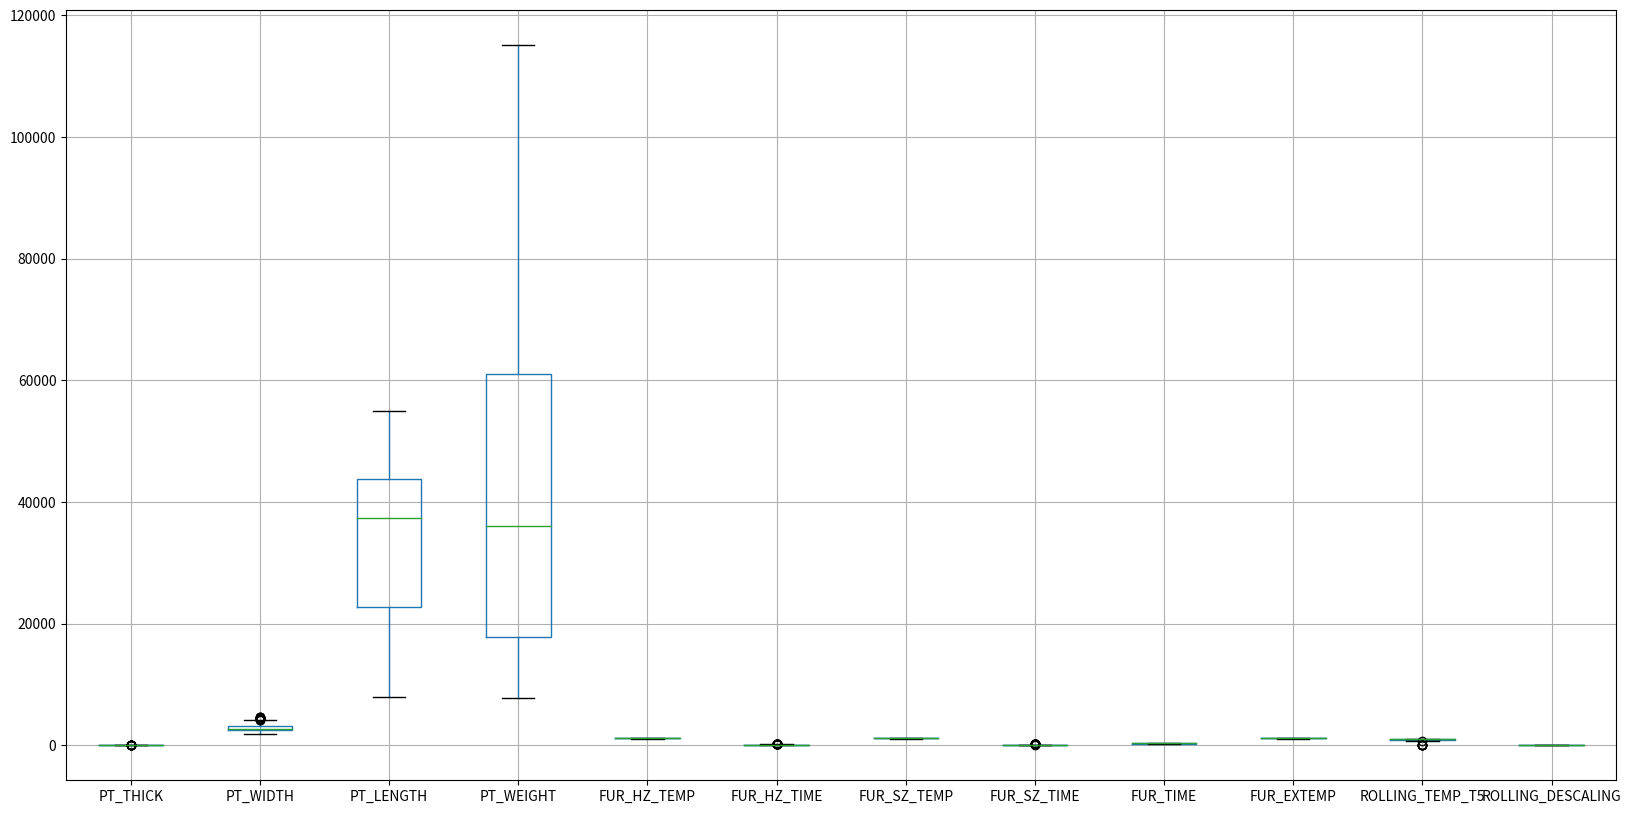

In [12]:
plt.figure(figsize=(20, 10))
df_raw.boxplot(['PT_THICK', 'PT_WIDTH', 'PT_LENGTH', 'PT_WEIGHT',
       'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME',
       'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'ROLLING_DESCALING'])

### PT_LENGTH와 PT_WEIGHT가 상대적으로 수치가 커, 제대로 비교하기 어렵기 때문에 두 변수를 분리 시켜줌

<AxesSubplot:>

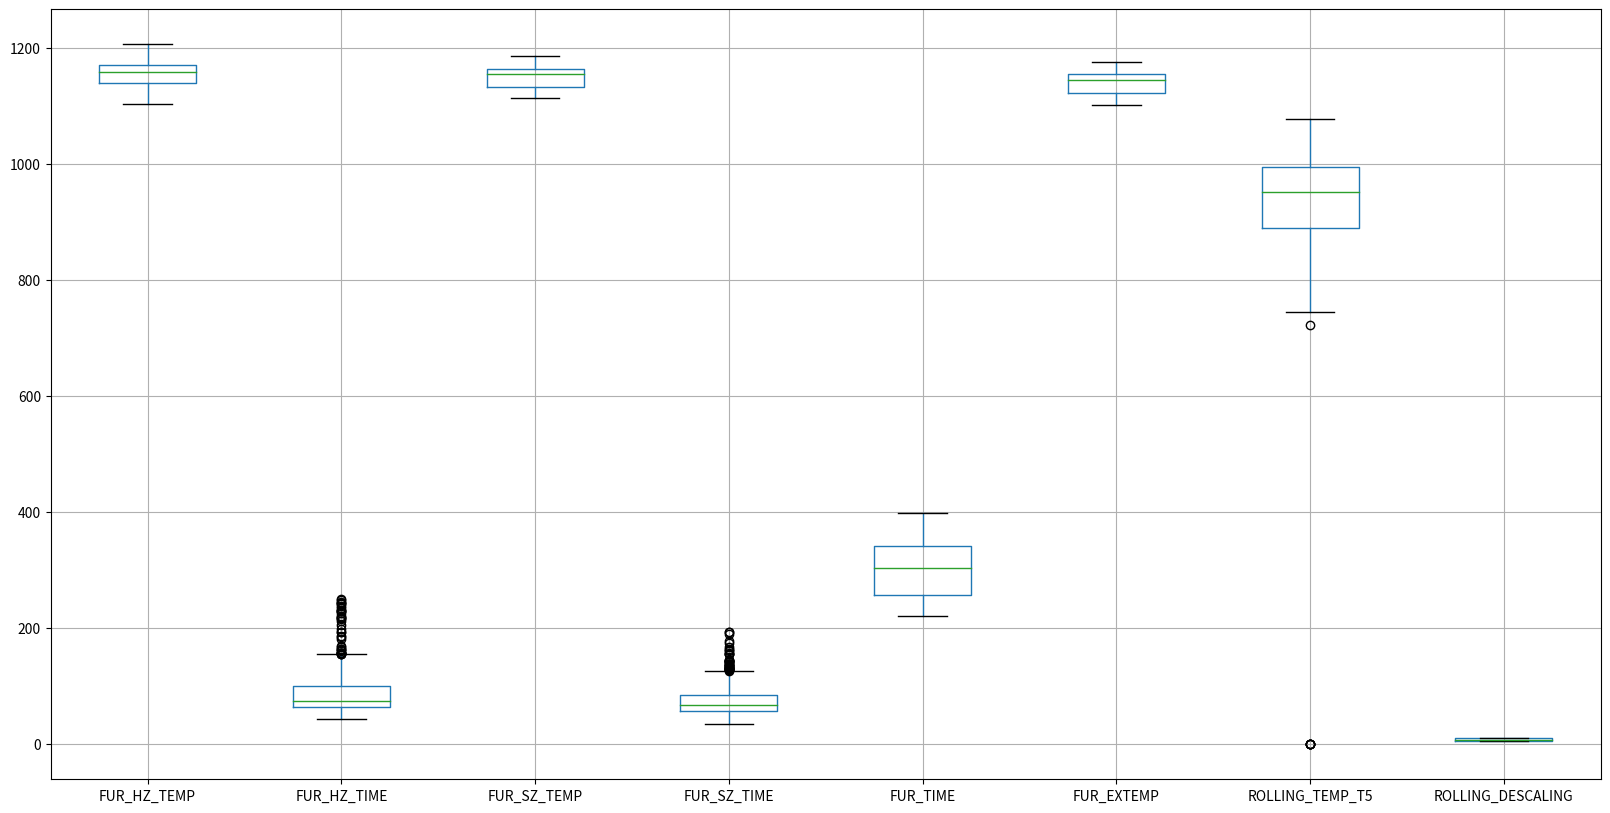

In [13]:
plt.figure(figsize=(20, 10))
df_raw.boxplot(['FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 
                'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'ROLLING_DESCALING'])

### 이상치가 없는 변수는 제거하고, 이상치가 보이는 데이터만 추출

<AxesSubplot:>

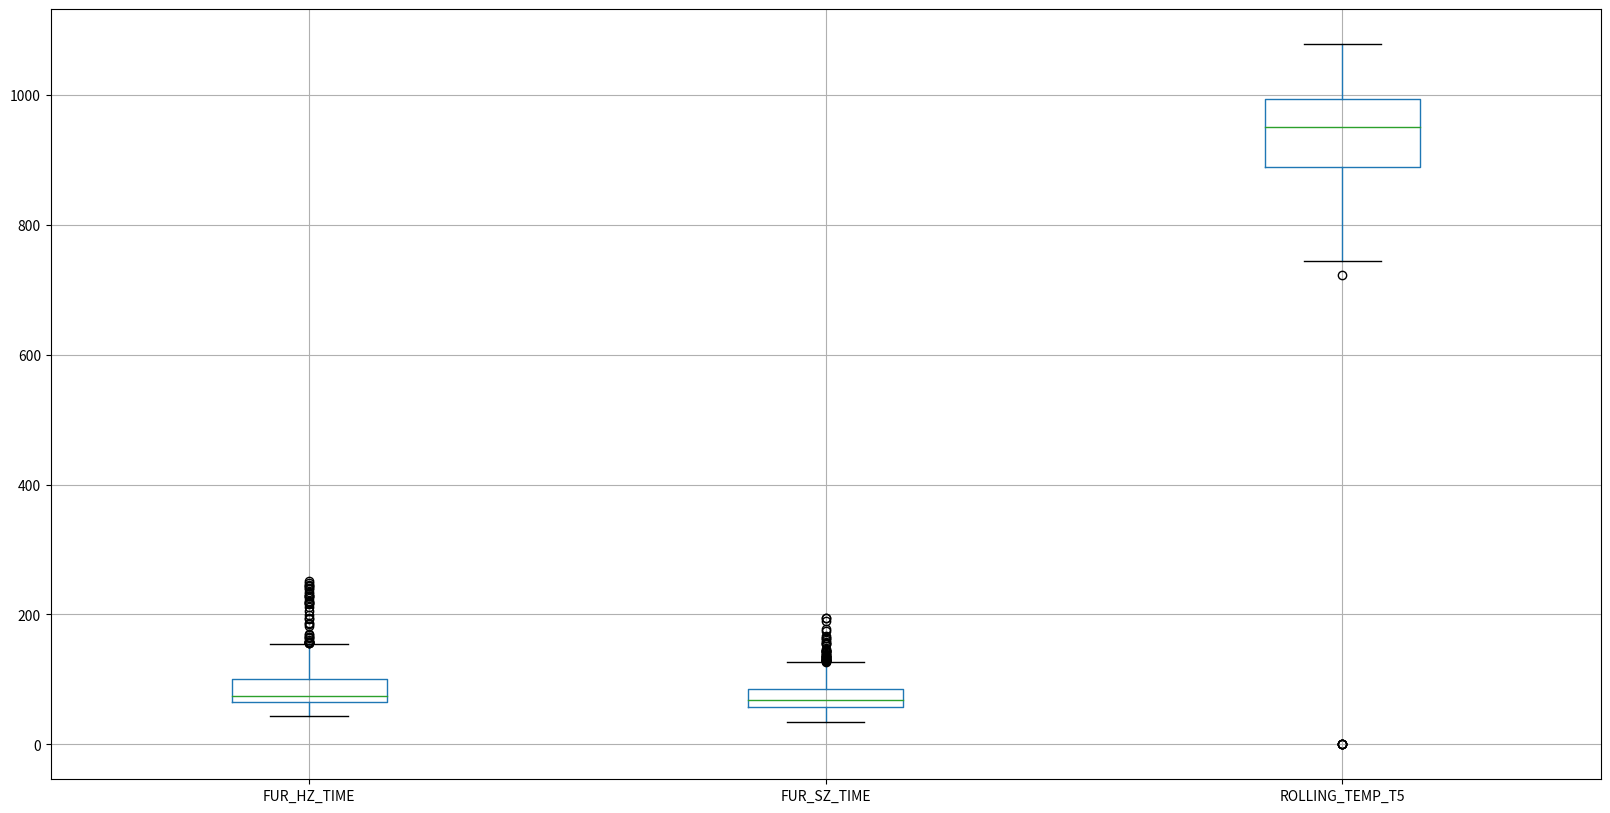

In [14]:
plt.figure(figsize=(20, 10))
df_raw.boxplot(['FUR_HZ_TIME', 'FUR_SZ_TIME', 'ROLLING_TEMP_T5'])

이상치는 디시전 트리에 큰 영향을 주기 때문에 디시전 트리를 이용하는 랜덤포레스트와 그래딘언트 부스팅을 위해 이상치를 제거하려고 한다. 하지만 FUR_HZ_TIME와 FUR_SZ_TIME 이상치를 제거하게 되면 너무 많은 데이터가 삭제되어 모델의 학습에 영향을 미칠 것이다. 하여 ROLLING_TEMP_T5의 0의 이상치만 제거한다. 


In [15]:
idx = df_raw[df_raw['ROLLING_TEMP_T5'] == 0].index
df_raw.drop(idx, inplace=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 719
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              714 non-null    int64  
 1   SPEC               714 non-null    int64  
 2   STEEL_KIND         714 non-null    int64  
 3   PT_THICK           714 non-null    float64
 4   PT_WIDTH           714 non-null    int64  
 5   PT_LENGTH          714 non-null    int64  
 6   PT_WEIGHT          714 non-null    int64  
 7   FUR_NO             714 non-null    int64  
 8   FUR_NO_ROW         714 non-null    int64  
 9   FUR_HZ_TEMP        714 non-null    int64  
 10  FUR_HZ_TIME        714 non-null    int64  
 11  FUR_SZ_TEMP        714 non-null    int64  
 12  FUR_SZ_TIME        714 non-null    int64  
 13  FUR_TIME           714 non-null    int64  
 14  FUR_EXTEMP         714 non-null    int64  
 15  ROLLING_TEMP_T5    714 non-null    int64  
 16  HSB                714 non

#  3. 그래프를 활용한 탐색적 분석

목표변수에 대한 각 설명변수들의 관게를 알아보기 위해 히스토그램을 사용

In [16]:
def fun_plot_hist(data, var):
    plt.hist(data[data["SCALE"] == 1][var], label = '1', alpha = 0.5) # 양품 1
    plt.hist(data[data["SCALE"] == 0][var], label = '0', alpha = 0.5) # 불량 0
    plt.legend()

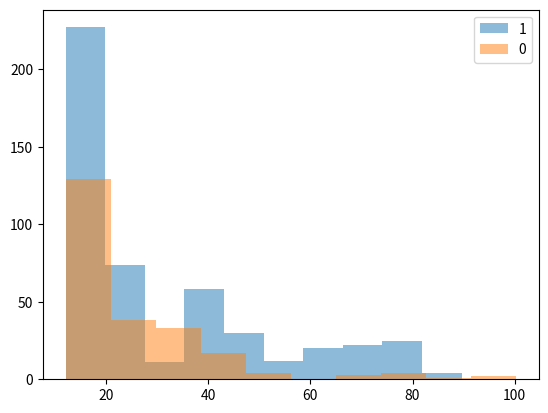

In [17]:
# plate 두께가 20전으로 불량이 가장 높게 나왔다.
fun_plot_hist(df_raw, "PT_THICK")

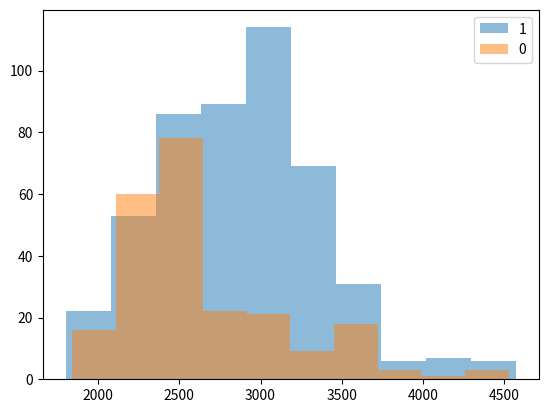

In [18]:
# plate 폭은 2000~2500사이에 가장 불량이 높은것으로 확인됨
fun_plot_hist(df_raw, "PT_WIDTH")

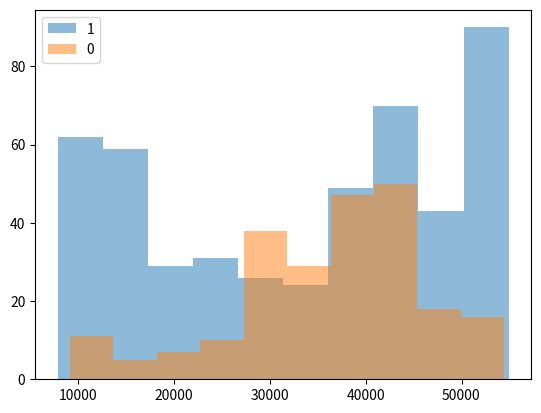

In [19]:
# plate 길이 2800~4500 사이에 불량률이 높음
fun_plot_hist(df_raw, "PT_LENGTH")

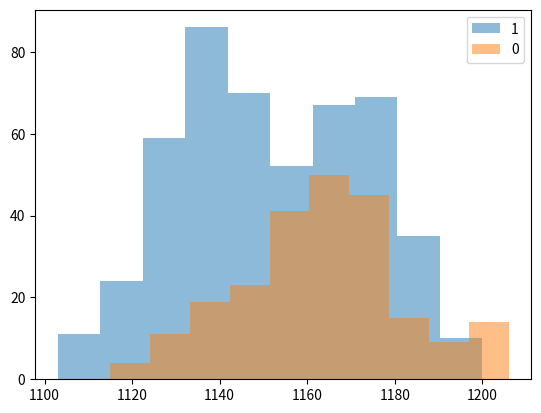

In [20]:
# 가열로 가열대 온도 1150~1170 사이에 불량율 높음
fun_plot_hist(df_raw, "FUR_HZ_TEMP")

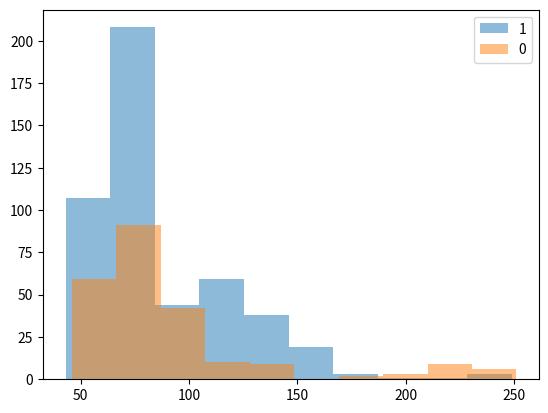

In [21]:
# 가열로 균열대 시간 50~ 100사이에 불량률이 높음
fun_plot_hist(df_raw, "FUR_HZ_TIME")

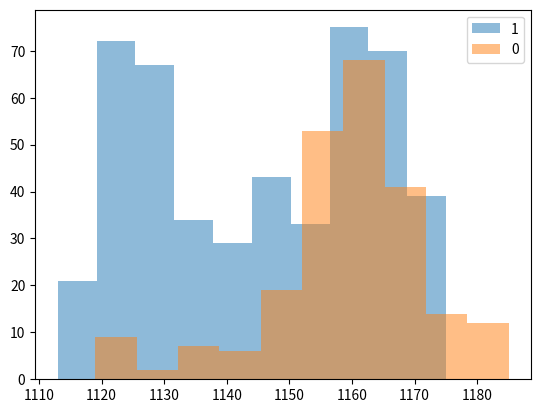

In [22]:
# 가열로 균열대 온도 1150~1170 사이에 불량율이 높음
fun_plot_hist(df_raw, "FUR_SZ_TEMP")

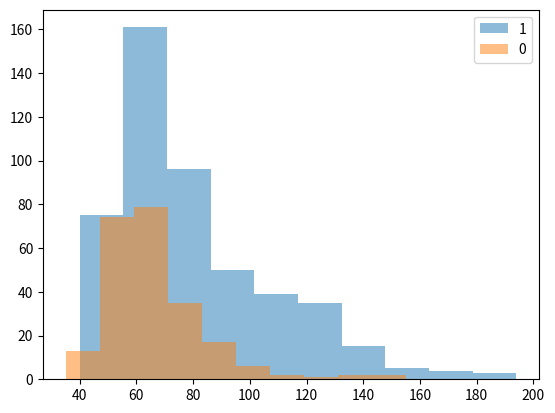

In [23]:
# 가열로 균열대 시간 50~70 사이에 불량률이 높음
fun_plot_hist(df_raw, "FUR_SZ_TIME")

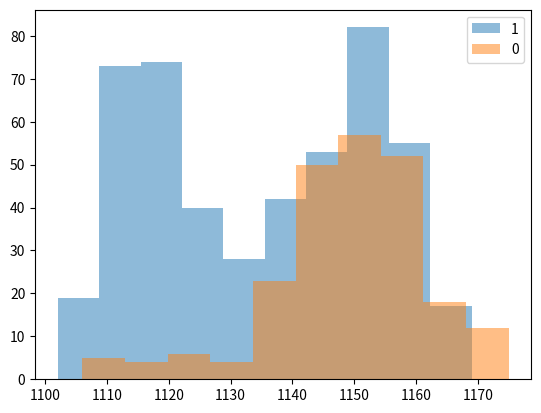

In [24]:
# 압연 온도 1140~1160 사이에 불량률이 높음
fun_plot_hist(df_raw, "FUR_EXTEMP")

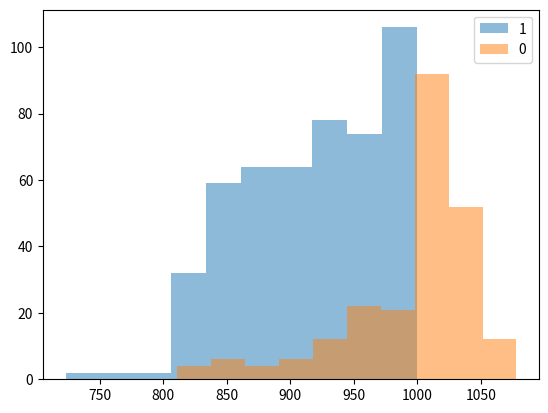

In [25]:
# 압연 온도 1000 ~ 1150사이에 불량률이 높음 / 압연 온도가 일반적인 평군이 1000 ~1100도이다. 하지만 평균적인 온도임에도 불량률이 높게 나왔다는 것은 문제가 있다고 판단이 된다. 이 설명변수가 목표변수에 큰 영향을 줄것이라고 판단이됨 
fun_plot_hist(df_raw, "ROLLING_TEMP_T5")

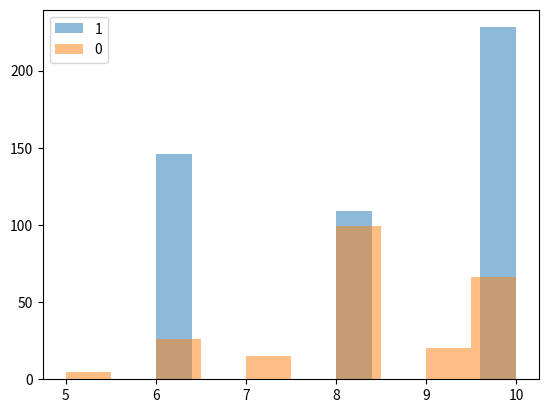

In [26]:
# 압연 중 Descaling 횟수가 홀수 일때는 불량률이 100%인 것을 확인 그리고 8번에 대한 불량률이 높은 것을 보니 무엇인가 영향을 크게 주는 것으로 판단이 됨 ROLLING_DESCALIMG에 영향을 주는 것이 무엇인지도 확인을 해보야 할듯
fun_plot_hist(df_raw, "ROLLING_DESCALING")

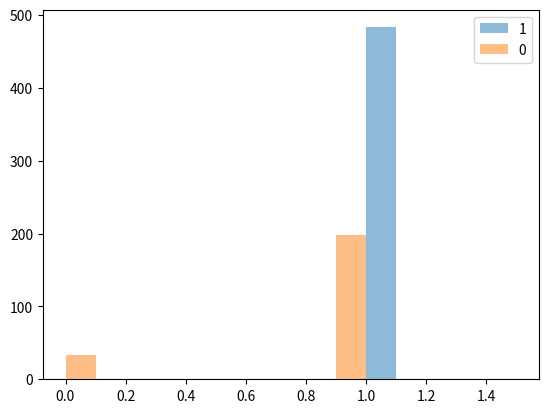

In [27]:
fun_plot_hist(df_raw, "HSB") # HSB는 적용하지 않았을 때 불량률이 발생한 것을 확인 

교차표

In [28]:
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))

In [29]:
# 가열로 호기를 살펴 봤을 때 불량률이 비슷하게 나왔으니 가열호기에 따라 목표변수에 대한 영향력은 크게 없다고 판단
fun_print_crosstab(df_raw, "FUR_NO")

FUR_NO    0    1    2
SCALE                
0        73   70   88
1       166  166  151

FUR_NO      0      1      2
SCALE                      
0       0.305  0.297  0.368
1       0.695  0.703  0.632


In [30]:
# HSB 적용 HSB를 적용하지 않을때 비율을 살펴보면 적용하지 않았을 때를 살펴보면 불량일 확률이 매우 높다. 적용 했을때는 70 : 30 으로 양품일 확률을 보여주지만 적용하지 않았을 때는 불량일 확률이 큼으로 목표변수에 어느정도 영향을 줄것이라고 판단이 됨
fun_print_crosstab(df_raw, "HSB")

HSB     0    1
SCALE         
0      33  198
1       0  483

HSB      0      1
SCALE            
0      1.0  0.291
1      0.0  0.709


In [31]:
# 작업조에 따라서도 불량률 비율을 본다면 크게 목표변수에 대한 영향을 미치지 않을 것이라고 판단
fun_print_crosstab(df_raw, "WORK_GR")

WORK_GR    0    1    2    3
SCALE                      
0         67   45   54   65
1        121  119  115  128

WORK_GR      0      1     2      3
SCALE                             
0        0.356  0.274  0.32  0.337
1        0.644  0.726  0.68  0.663


In [32]:
# 후판강종 따라 불량룰을 검증해 보았을때 CO가 불량률 50%로 가장 높게 나왔다. 즉 철강이 Co일때 가장 불량률이 높음
fun_print_crosstab(df_raw, "STEEL_KIND")

STEEL_KIND    0  1  2   3   4  5   6   7   8
SCALE                                       
0           212  1  1   2   2  0   2   6   5
1           289  0  6  13  16  2  39  29  89

STEEL_KIND      0    1      2      3      4    5      6      7      8
SCALE                                                                
0           0.423  1.0  0.143  0.133  0.111  0.0  0.049  0.171  0.053
1           0.577  0.0  0.857  0.867  0.889  1.0  0.951  0.829  0.947


히스토드램과 교차표를 이용해 목표변수에 영향을 주는 설명변수들을 뽑아 보면 PT_THICK(후판 지시 두께), PT_WIDTH(후판 지시 폭), PT_LENGTH(후판 지시 길이), FUR_HZ_TEMP(가열로 가열대 소재온도), FUR_SZ_TEMP(가열로 균열대 소재온도), FUR_SZ_TIME(가열로 균열대 재로시간), FUR_EXTEMP(가열로 추출온도), ROLLING_TEMP_T5(압연 온도), ROLLING_DESCALING(압연 descaling 횟수), STEEL_KIND(후판강종)

총 목표변수에 영향을 줄것이라고 판단되는 설면변수는 총 10개로 생각되고 있다.

# 4. 데이터 분류분석
 ## 1) 로지스틱 회귀분석

단위가 다를 것을 염두하고 standard scale 진행

In [33]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw, test_size = 0.3,random_state = 1234)  # random state

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (499, 19)
test data size : (215, 19)


In [34]:
log_model = Logit.from_formula("""SCALE~ SPEC+STEEL_KIND+PT_THICK+PT_WIDTH+PT_LENGTH+PT_WEIGHT+FUR_NO+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+WORK_GR+HSB""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.282960
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  499
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                           17
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                  0.5490
Time:                        20:24:02   Log-Likelihood:                -141.20
converged:                      False   LL-Null:                       -313.05
Covariance Type:            nonrobust   LLR p-value:                 1.003e-62
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          83.1538   4.65e+04      0.002      0.999   -9.11e+04    9.13e+04
SPEC                0.0047      0.010      0.491  

/home/piai/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
# train 데이터 예측
y_pred_train = log_result.predict(df_train)

# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print("Train 예측 결과 \n", y_pred_train_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["SCALE"], y_pred_train_class)),"\n")

# test 데이터 예측
y_pred_test = log_result.predict(df_test)

# 0과 1의 값을 가진 class로 변환
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("Test 예측 결과 \n", y_pred_test_class.head(),"\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"],y_pred_test_class)),"\n")

Train 예측 결과 
 209    0
60     1
13     1
152    0
488    1
dtype: int64 

Confusion Matrix: 
[[129  31]
 [ 24 315]] 

Test 예측 결과 
 528    1
476    1
651    1
270    1
447    1
dtype: int64 

Confusion Matrix: 
[[ 54  17]
 [ 15 129]] 



In [36]:
# 실제 train 데이터와 예측 결과 비교
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["SCALE"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["SCALE"],y_pred_train_class)),"\n")
print(classification_report(df_train["SCALE"], y_pred_train_class, digits=3))

# 실제 train 데이터와 예측 결과 비교
print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"],y_pred_test_class)),"\n")
print(classification_report(df_test["SCALE"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.890

Confusion Matrix: 
[[129  31]
 [ 24 315]] 

              precision    recall  f1-score   support

           0      0.843     0.806     0.824       160
           1      0.910     0.929     0.920       339

    accuracy                          0.890       499
   macro avg      0.877     0.868     0.872       499
weighted avg      0.889     0.890     0.889       499

Test 예측/분류 결과
Accuracy: 0.851

Confusion Matrix: 
[[ 54  17]
 [ 15 129]] 

              precision    recall  f1-score   support

           0      0.783     0.761     0.771        71
           1      0.884     0.896     0.890       144

    accuracy                          0.851       215
   macro avg      0.833     0.828     0.831       215
weighted avg      0.850     0.851     0.851       215



실제 0을 0으로 분류한것은 142개(TP) / 실제 1을 0으로 분류한 것은 26(FP) / 실제 0을 1로 분류한 것은 38(FN) / 실제 1을 1로 분류한 것은 365(TN)



모델의 학습률은 93%로 모델의 최종 성능은 92%로 생각보다 높은 정확도가 나왔다.

<AxesSubplot:>

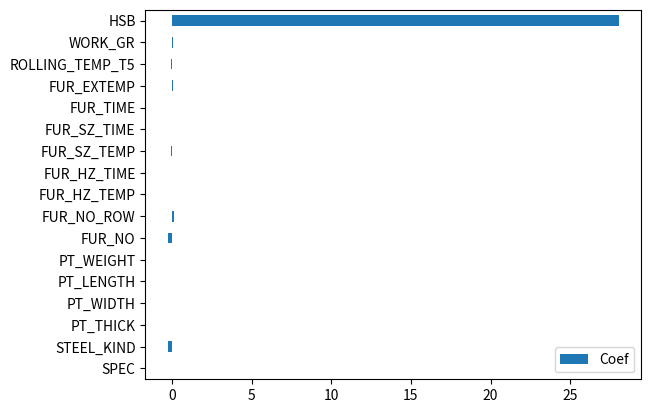

In [37]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")
# df_logistic_coef.plot.barh(y = "Coef", figsize=(10,6))

### 위에 돌린것은 단위를 맞추지 않고 진행 하였다. Standard scale 적용해 비교해 보려고 한다. 표준화

In [38]:
v_feature_names = df_raw.columns

sc = StandardScaler()
df_scaled = sc.fit_transform(df_raw)
df_scaled =pd.DataFrame(df_scaled, columns= v_feature_names)
df_scaled.head()

,SCALE,SPEC,STEEL_KIND,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0.691564,-1.679348,0.656932,0.165524,1.738825,-1.399249,-1.102663,-1.22218,-0.994413,-0.550140,0.764075,-0.958762,-0.626900,-0.401705,-0.824152,-0.118132,0.220132,-0.202656,-0.447888
1,0.691564,-1.679348,0.656932,0.165524,1.738825,-1.399249,-1.102663,-1.22218,1.005618,-0.550140,0.929201,-0.844450,-0.856285,-0.379613,-1.105167,-0.072514,0.220132,-0.202656,-0.447888
2,0.691564,1.560703,1.932390,0.219261,1.568260,-1.103953,-0.943272,0.00000,-0.994413,-1.270256,0.764075,-1.644633,-0.779823,-0.401705,-1.892008,-0.802387,0.220132,-0.202656,0.423480
3,0.691564,1.560703,1.932390,0.219261,1.568260,-1.103953,-0.943272,0.00000,1.005618,-0.166077,1.011765,-1.301698,-0.282822,0.349415,-1.498588,-0.863210,0.220132,-0.202656,0.423480
4,0.691564,-1.090248,1.932390,0.485835,0.558436,-1.527970,-1.173279,1.22218,-0.994413,-0.742171,1.259454,-1.244542,-1.047439,0.305232,-1.217573,-1.045678,0.220132,-0.202656,-1.319257


In [39]:
# SCALE 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled["SCALE"] = np.where(df_scaled["SCALE"]> 0, 1, 0)
df_scaled.head()

,SCALE,SPEC,STEEL_KIND,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,1,-1.679348,0.656932,0.165524,1.738825,-1.399249,-1.102663,-1.22218,-0.994413,-0.550140,0.764075,-0.958762,-0.626900,-0.401705,-0.824152,-0.118132,0.220132,-0.202656,-0.447888
1,1,-1.679348,0.656932,0.165524,1.738825,-1.399249,-1.102663,-1.22218,1.005618,-0.550140,0.929201,-0.844450,-0.856285,-0.379613,-1.105167,-0.072514,0.220132,-0.202656,-0.447888
2,1,1.560703,1.932390,0.219261,1.568260,-1.103953,-0.943272,0.00000,-0.994413,-1.270256,0.764075,-1.644633,-0.779823,-0.401705,-1.892008,-0.802387,0.220132,-0.202656,0.423480
3,1,1.560703,1.932390,0.219261,1.568260,-1.103953,-0.943272,0.00000,1.005618,-0.166077,1.011765,-1.301698,-0.282822,0.349415,-1.498588,-0.863210,0.220132,-0.202656,0.423480
4,1,-1.090248,1.932390,0.485835,0.558436,-1.527970,-1.173279,1.22218,-0.994413,-0.742171,1.259454,-1.244542,-1.047439,0.305232,-1.217573,-1.045678,0.220132,-0.202656,-1.319257


In [40]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_scaled, test_size = 0.3,random_state = 1234)  # random state

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (499, 19)
test data size : (215, 19)


In [41]:
log_model = Logit.from_formula("""SCALE~ SPEC+STEEL_KIND+PT_THICK+PT_WIDTH+PT_LENGTH+PT_WEIGHT+FUR_NO+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+ROLLING_DESCALING+WORK_GR+HSB""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.263695
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  499
Model:                          Logit   Df Residuals:                      480
Method:                           MLE   Df Model:                           18
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                  0.5797
Time:                        20:24:03   Log-Likelihood:                -131.58
converged:                       True   LL-Null:                       -313.05
Covariance Type:            nonrobust   LLR p-value:                 4.734e-66
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0132   4.52e+06   2.93e-09      1.000   -8.85e+06    8.85e+06
SPEC   

In [42]:
# train 데이터 예측
y_pred_train = log_result.predict(df_train)

# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print("Train 예측 결과 \n", y_pred_train_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["SCALE"], y_pred_train_class)),"\n")

# test 데이터 예측
y_pred_test = log_result.predict(df_test)

# 0과 1의 값을 가진 class로 변환
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("Test 예측 결과 \n", y_pred_test_class.head(),"\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"],y_pred_test_class)),"\n")

Train 예측 결과 
 206    0
59     1
13     1
151    0
485    1
dtype: int64 

Confusion Matrix: 
[[130  30]
 [ 24 315]] 

Test 예측 결과 
 522    1
473    1
645    1
267    1
444    1
dtype: int64 

Confusion Matrix: 
[[ 54  17]
 [ 13 131]] 



In [43]:
# 실제 train 데이터와 예측 결과 비교
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["SCALE"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["SCALE"],y_pred_train_class)),"\n")
print(classification_report(df_train["SCALE"], y_pred_train_class, digits=3))

# 실제 train 데이터와 예측 결과 비교
print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"],y_pred_test_class)),"\n")
print(classification_report(df_test["SCALE"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.892

Confusion Matrix: 
[[130  30]
 [ 24 315]] 

              precision    recall  f1-score   support

           0      0.844     0.812     0.828       160
           1      0.913     0.929     0.921       339

    accuracy                          0.892       499
   macro avg      0.879     0.871     0.875       499
weighted avg      0.891     0.892     0.891       499

Test 예측/분류 결과
Accuracy: 0.860

Confusion Matrix: 
[[ 54  17]
 [ 13 131]] 

              precision    recall  f1-score   support

           0      0.806     0.761     0.783        71
           1      0.885     0.910     0.897       144

    accuracy                          0.860       215
   macro avg      0.846     0.835     0.840       215
weighted avg      0.859     0.860     0.859       215



<AxesSubplot:>

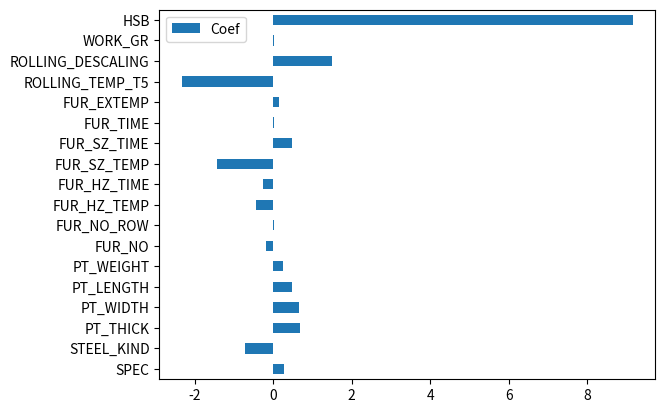

In [44]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")
# df_logistic_coef.plot.barh(y = "Coef", figsize=(10,6))

설명변수들의 표준화를 진행후 변수 중요도를 확인해 보니 

## 의사결정 트리

In [45]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

In [46]:
# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train", df_train_x.shape, "Test",df_test_x.shape)

분할 전 설명변수 데이터 : (714, 18)
분할 후 설명변수 데이터 : Train (499, 18) Test (215, 18)


In [47]:
model = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [depth for depth in range(2, 5)],
              "min_samples_split": [sample_split for sample_split in range(2, 31)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(2, 11)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

best parameter: 
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

best score: 
0.974


In [48]:
dt_final = DecisionTreeClassifier(criterion = "gini", max_depth = 4, min_samples_leaf = 2, min_samples_split = 2)
dt_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

In [49]:
# df_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = df_train_x.columns
ds_feature_importance["importance"] = dt_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
14,ROLLING_TEMP_T5,0.632031
15,HSB,0.194832
10,FUR_SZ_TEMP,0.125783
16,ROLLING_DESCALING,0.047354
0,SPEC,0.000000
1,STEEL_KIND,0.000000
13,FUR_EXTEMP,0.000000
12,FUR_TIME,0.000000
11,FUR_SZ_TIME,0.000000
9,FUR_HZ_TIME,0.000000


Text(0, 0.5, '설명변수')

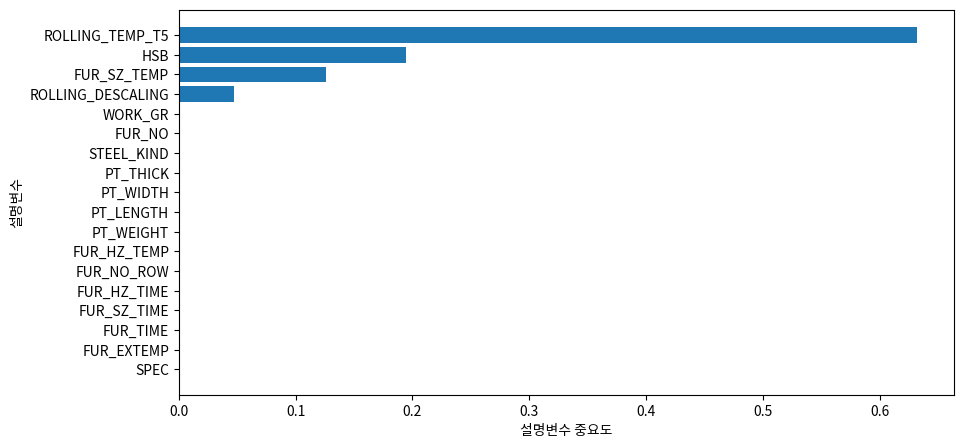

In [50]:
ds_feature_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(ds_feature_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = ds_feature_importance["importance"])
plt.yticks(coordinates, ds_feature_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 데이터 표준화 했을때

In [51]:
df_raw_x = df_scaled.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_scaled["SCALE"] 

In [52]:
# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train", df_train_x.shape, "Test",df_test_x.shape)

분할 전 설명변수 데이터 : (714, 18)
분할 후 설명변수 데이터 : Train (499, 18) Test (215, 18)


## 모델생성

In [53]:
model = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [depth for depth in range(2, 5)],
              "min_samples_split": [sample_split for sample_split in range(2, 31)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(2, 11)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

best parameter: 
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

best score: 
0.974


In [54]:
dt_final = DecisionTreeClassifier(criterion = "gini", max_depth = 4, min_samples_leaf = 2, min_samples_split = 2)
dt_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)

In [55]:
# df_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = df_train_x.columns
ds_feature_importance["importance"] = dt_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
14,ROLLING_TEMP_T5,0.632031
15,HSB,0.194832
10,FUR_SZ_TEMP,0.125783
16,ROLLING_DESCALING,0.047354
0,SPEC,0.000000
1,STEEL_KIND,0.000000
13,FUR_EXTEMP,0.000000
12,FUR_TIME,0.000000
11,FUR_SZ_TIME,0.000000
9,FUR_HZ_TIME,0.000000


Text(0, 0.5, '설명변수')

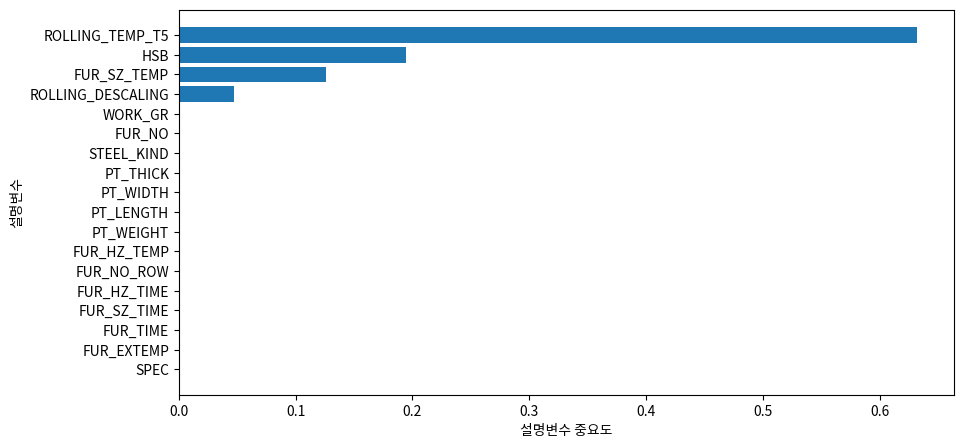

In [56]:
ds_feature_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(ds_feature_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = ds_feature_importance["importance"])
plt.yticks(coordinates, ds_feature_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 랜덤 포레스트 

In [57]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [58]:
model = RandomForestClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [depth for depth in range(3, 11)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(10, 21)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10)

best parameter: 
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}

best score: 
0.906


In [59]:
rf_final = RandomForestClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 10, n_estimators = 500)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       n_estimators=500)

In [60]:
# rf_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = df_train_x.columns
ds_feature_importance["importance"] = rf_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
14,ROLLING_TEMP_T5,0.385310
10,FUR_SZ_TEMP,0.098033
13,FUR_EXTEMP,0.082698
3,PT_WIDTH,0.077122
15,HSB,0.058305
2,PT_THICK,0.045447
4,PT_LENGTH,0.040335
8,FUR_HZ_TEMP,0.039356
16,ROLLING_DESCALING,0.035234
12,FUR_TIME,0.028638


Text(0, 0.5, '설명변수')

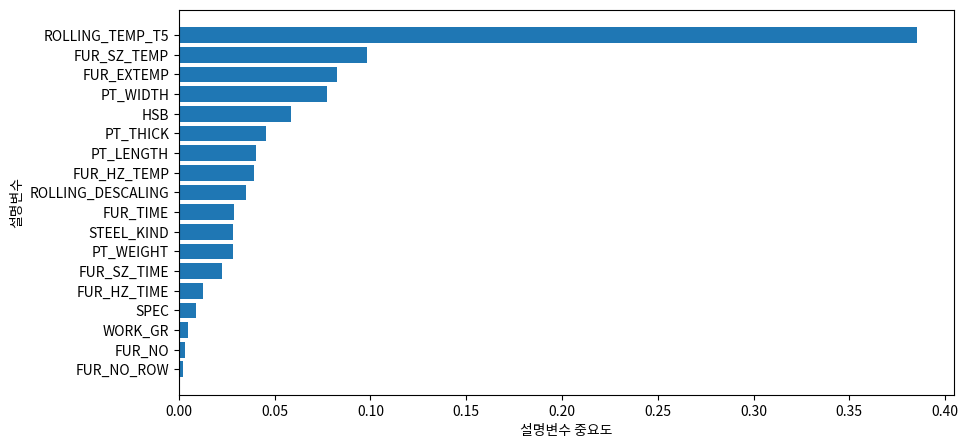

In [61]:
ds_feature_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(ds_feature_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = ds_feature_importance["importance"])
plt.yticks(coordinates, ds_feature_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

모델 생성
Default option Moel

표준화 했을떄

In [62]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [63]:
model = RandomForestClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [depth for depth in range(3, 11)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(10, 21)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10)

best parameter: 
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}

best score: 
0.904


In [64]:
rf_final = RandomForestClassifier(criterion = "gini", max_depth = 8, min_samples_leaf = 10, n_estimators = 500)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(max_depth=8, min_samples_leaf=10, n_estimators=500)

In [65]:
# rf_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = df_train_x.columns
ds_feature_importance["importance"] = rf_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
14,ROLLING_TEMP_T5,0.381318
10,FUR_SZ_TEMP,0.099690
3,PT_WIDTH,0.093041
13,FUR_EXTEMP,0.083234
2,PT_THICK,0.060120
15,HSB,0.054094
8,FUR_HZ_TEMP,0.040927
4,PT_LENGTH,0.037153
16,ROLLING_DESCALING,0.032603
12,FUR_TIME,0.025128


Text(0, 0.5, '설명변수')

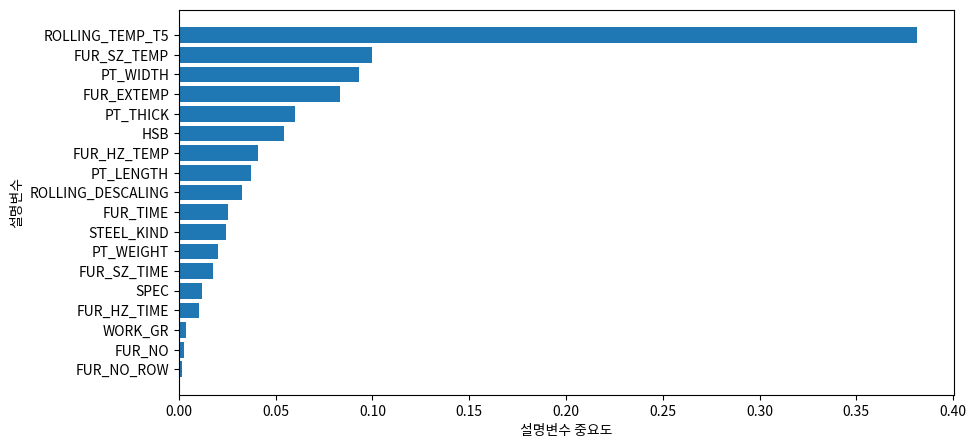

In [66]:
ds_feature_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(ds_feature_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = ds_feature_importance["importance"])
plt.yticks(coordinates, ds_feature_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 그래디언트 부스팅

표준화하지 않았을때

In [67]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

모델 생성

In [68]:
model = GradientBoostingClassifier()
param_grid = {"learning_rate": [rate / 10 for rate in range(1, 5)],
              "max_depth": [depth for depth in range(3, 11)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(10, 21)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
GradientBoostingClassifier(learning_rate=0.4, min_samples_leaf=10)

best parameter: 
{'learning_rate': 0.4, 'max_depth': 3, 'min_samples_leaf': 10}

best score: 
0.978


In [69]:
gb_final = GradientBoostingClassifier(learning_rate = 0.3, max_depth = 5, min_samples_leaf = 10)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_leaf=10)

In [70]:
# gb_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = df_train_x.columns
ds_feature_importance["importance"] = gb_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
14,ROLLING_TEMP_T5,0.595199
15,HSB,0.182268
10,FUR_SZ_TEMP,0.122575
2,PT_THICK,0.046942
16,ROLLING_DESCALING,0.017489
4,PT_LENGTH,0.009412
8,FUR_HZ_TEMP,0.004343
3,PT_WIDTH,0.004220
5,PT_WEIGHT,0.003667
17,WORK_GR,0.003562


Text(0, 0.5, '설명변수')

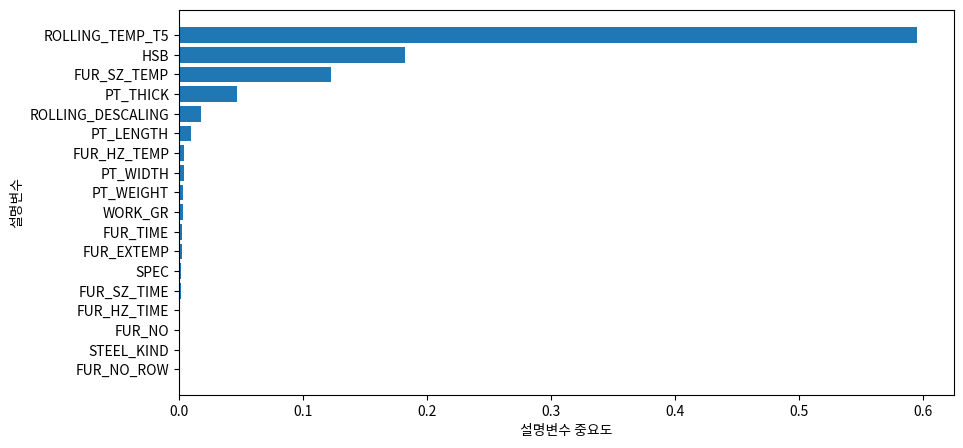

In [71]:
ds_feature_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(ds_feature_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = ds_feature_importance["importance"])
plt.yticks(coordinates, ds_feature_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

표준화 했을때

In [72]:
df_raw_x = df_scaled.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_scaled["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [73]:
model = GradientBoostingClassifier()
param_grid = {"learning_rate": [rate / 10 for rate in range(1, 5)],
              "max_depth": [depth for depth in range(3, 11)],
              "min_samples_leaf": [sample_leaf for sample_leaf in range(10, 21)]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
GradientBoostingClassifier(learning_rate=0.4, min_samples_leaf=10)

best parameter: 
{'learning_rate': 0.4, 'max_depth': 3, 'min_samples_leaf': 10}

best score: 
0.978


In [74]:
gb_final = GradientBoostingClassifier(learning_rate = 0.3, max_depth = 5, min_samples_leaf = 10)
gb_final.fit(df_train_x, df_train_y)


GradientBoostingClassifier(learning_rate=0.3, max_depth=5, min_samples_leaf=10)

In [75]:
# gb_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = df_train_x.columns
ds_feature_importance["importance"] = gb_final.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False)

,feature,importance
14,ROLLING_TEMP_T5,0.595199
15,HSB,0.182268
10,FUR_SZ_TEMP,0.122574
2,PT_THICK,0.047024
16,ROLLING_DESCALING,0.017407
4,PT_LENGTH,0.009412
8,FUR_HZ_TEMP,0.004343
3,PT_WIDTH,0.004220
5,PT_WEIGHT,0.003667
17,WORK_GR,0.003562


Text(0, 0.5, '설명변수')

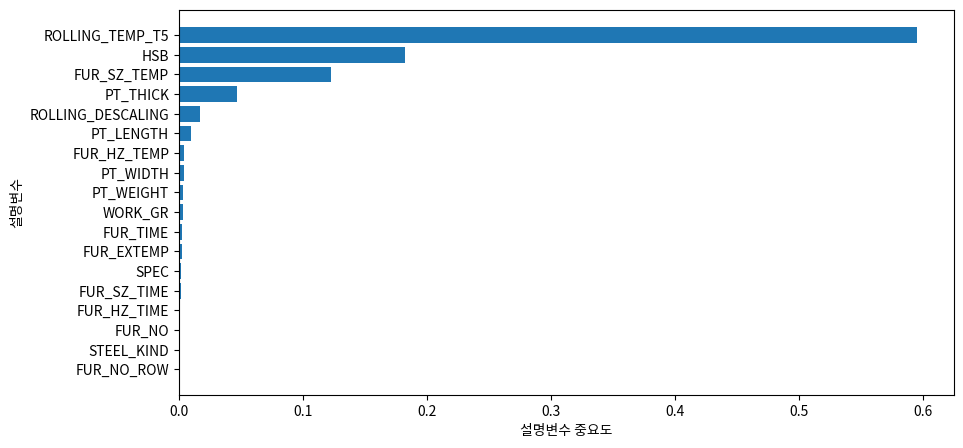

In [76]:
ds_feature_importance.sort_values("importance", ascending=True, inplace = True)
coordinates = range(len(ds_feature_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = ds_feature_importance["importance"])
plt.yticks(coordinates, ds_feature_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## KNN

## 표준화 하지 않았을 떄

In [77]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [78]:
n_iter_neighbor = 50
neighbor_range = [i+1 for i in range(n_iter_neighbor)]
train_accuracy = []; test_accuracy = []
for n_neighbor in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors = n_neighbor)
    knn.fit(df_train_x, df_train_y)
    # 각 데이터로부터 가장 가까운 군집 중심점까지 거리 제곱합
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

In [79]:
ds_accuracy = pd.DataFrame({"NumberOfNeighbors": neighbor_range, "TrainAccuracy": train_accuracy, "TestAccuracy": test_accuracy})
ds_accuracy.round(3)

,NumberOfNeighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.670
1,2,0.850,0.637
2,3,0.848,0.688
3,4,0.822,0.698
4,5,0.830,0.665
5,6,0.810,0.688
6,7,0.792,0.684
7,8,0.780,0.702
8,9,0.784,0.707
9,10,0.774,0.688


<AxesSubplot:xlabel='NumberOfNeighbors', ylabel='value'>

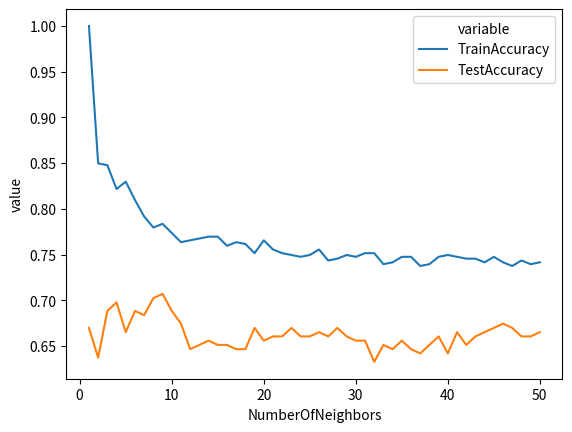

In [80]:
ds_accuracy_melt = pd.melt(ds_accuracy, id_vars = "NumberOfNeighbors")
sns.lineplot(x = "NumberOfNeighbors", y = "value", hue = "variable", data = ds_accuracy_melt)

In [81]:
# 최종 모델
knn_model = KNeighborsClassifier(n_neighbors = n_neighbor)
knn_model.fit(df_train_x, df_train_y)
y_pred = knn_model.predict(df_test_x)
# train 데이터 셋 정확도
print("train data accuracy: {0:.3f}".format(knn_model.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("test data accuracy: {0:.3f}\n".format(knn_model.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

train data accuracy: 0.741
test data accuracy: 0.665

Confusion matrix: 
[[ 21  50]
 [ 22 122]]
              precision    recall  f1-score   support

           0      0.488     0.296     0.368        71
           1      0.709     0.847     0.772       144

    accuracy                          0.665       215
   macro avg      0.599     0.571     0.570       215
weighted avg      0.636     0.665     0.639       215



In [82]:
model = KNeighborsClassifier(n_neighbors = n_neighbor)
param_grid = {
              "metric": ["euclidean" , "manhattan" ],
              "weights": ["uniform"  , "distance" ]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')

best parameter: 
{'metric': 'manhattan', 'weights': 'distance'}

best score: 
0.746


In [83]:
#kn_final = GradientBoostingClassifier(  )
#kn_final.fit(df_train_x, df_train_y)


표준화 했을때

In [84]:
df_raw_x = df_scaled.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_scaled["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [85]:
n_iter_neighbor = 50
neighbor_range = [i+1 for i in range(n_iter_neighbor)]
train_accuracy = []; test_accuracy = []
for n_neighbor in neighbor_range:
    knn = KNeighborsClassifier(n_neighbors = n_neighbor)
    knn.fit(df_train_x, df_train_y)
    # 각 데이터로부터 가장 가까운 군집 중심점까지 거리 제곱합
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

In [86]:
ds_accuracy = pd.DataFrame({"NumberOfNeighbors": neighbor_range, "TrainAccuracy": train_accuracy, "TestAccuracy": test_accuracy})
ds_accuracy.round(3)

,NumberOfNeighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.828
1,2,0.928,0.814
2,3,0.930,0.847
3,4,0.918,0.851
4,5,0.918,0.851
5,6,0.914,0.842
6,7,0.900,0.833
7,8,0.896,0.833
8,9,0.892,0.847
9,10,0.896,0.837


<AxesSubplot:xlabel='NumberOfNeighbors', ylabel='value'>

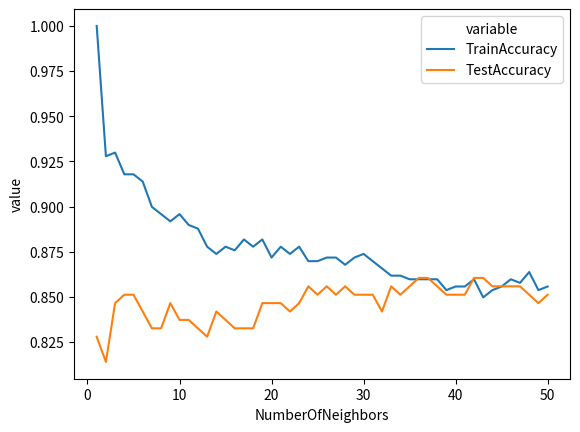

In [87]:
ds_accuracy_melt = pd.melt(ds_accuracy, id_vars = "NumberOfNeighbors")
sns.lineplot(x = "NumberOfNeighbors", y = "value", hue = "variable", data = ds_accuracy_melt)

In [88]:
# 최종 모델
knn_model = KNeighborsClassifier(n_neighbors = n_neighbor)
knn_model.fit(df_train_x, df_train_y)
y_pred = knn_model.predict(df_test_x)
# train 데이터 셋 정확도
print("train data accuracy: {0:.3f}".format(knn_model.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("test data accuracy: {0:.3f}\n".format(knn_model.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

train data accuracy: 0.856
test data accuracy: 0.851

Confusion matrix: 
[[ 47  24]
 [  8 136]]
              precision    recall  f1-score   support

           0      0.855     0.662     0.746        71
           1      0.850     0.944     0.895       144

    accuracy                          0.851       215
   macro avg      0.852     0.803     0.820       215
weighted avg      0.852     0.851     0.846       215



In [89]:
model = KNeighborsClassifier(n_neighbors = n_neighbor)
param_grid = {
              "metric": ["euclidean" , "manhattan" ],
              "weights": ["uniform"  , "distance" ]}

grid_dt = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')

best parameter: 
{'metric': 'manhattan', 'weights': 'distance'}

best score: 
0.844


## SVM

표준화 안헀을 떄

In [90]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [91]:
# 최종 모델
svc_final = SVC(random_state=1234)
svc_final.fit(df_train_x, df_train_y)
# 평가
y_pred = svc_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accucary on training set: {:.3f}".format(svc_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(svc_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Accucary on training set: 0.679
Accuracy on test set: 0.670

Confusion matrix: 
[[  0  71]
 [  0 144]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        71
           1      0.670     1.000     0.802       144

    accuracy                          0.670       215
   macro avg      0.335     0.500     0.401       215
weighted avg      0.449     0.670     0.537       215



/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
SVM_model = SVC(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"C": [c * 0.1 for c in range(1,21)],
              "gamma": [0.05 * gamma for gamma in range(1, 15)]}
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(SVM_model, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=0.1, gamma=0.05, random_state=1234)

best parameter: 
{'C': 0.1, 'gamma': 0.05}

best score: 
0.679


표준화 했을 때

In [93]:
df_raw_x = df_scaled.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_scaled["SCALE"] 

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [94]:
# 최종 모델
svc_final = SVC(random_state=1234)
svc_final.fit(df_train_x, df_train_y)
# 평가
y_pred = svc_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accucary on training set: {:.3f}".format(svc_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(svc_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Accucary on training set: 0.932
Accuracy on test set: 0.884

Confusion matrix: 
[[ 53  18]
 [  7 137]]
              precision    recall  f1-score   support

           0      0.883     0.746     0.809        71
           1      0.884     0.951     0.916       144

    accuracy                          0.884       215
   macro avg      0.884     0.849     0.863       215
weighted avg      0.884     0.884     0.881       215



In [95]:
SVM_model = SVC(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"C": [c * 0.1 for c in range(1,21)],
              "gamma": [0.05 * gamma for gamma in range(1, 15)]}
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(SVM_model, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=1.1, gamma=0.1, random_state=1234)

best parameter: 
{'C': 1.1, 'gamma': 0.1}

best score: 
0.898


## NN 분류

표준화 하지 않았을 때

In [96]:
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"] 

In [97]:
# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train", df_train_x.shape, "Test",df_test_x.shape)

분할 전 설명변수 데이터 : (714, 18)
분할 후 설명변수 데이터 : Train (499, 18) Test (215, 18)


In [98]:
mlp_model = MLPClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"hidden_layer_sizes" :[5 * hidden for hidden in range(1, 21)],
              "batch_size":  [20 * batch for batch in range(1, 10)] ,
              #"activation": ["logistic", "tanh", "relu"],
              "solver": ['lbfgs', 'sgd', 'adam']}

# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(mlp_model, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH

best estimator model: 
MLPClassifier(batch_size=60, hidden_layer_sizes=55, random_state=1234)

best parameter: 
{'batch_size': 60, 'hidden_layer_sizes': 55, 'solver': 'adam'}

best score: 
0.721


표준화 진행

In [102]:
df_raw_x = df_scaled.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_scaled["SCALE"] 

In [103]:
# 데이터 분할 train_test_split(X: 설명변수, Y: 목표변수, test_size = test 데이터 비율)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train", df_train_x.shape, "Test",df_test_x.shape)

분할 전 설명변수 데이터 : (714, 18)
분할 후 설명변수 데이터 : Train (499, 18) Test (215, 18)


In [104]:
mlp_model = MLPClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid = {"hidden_layer_sizes" :[5 * hidden for hidden in range(1, 21)],
              "batch_size":  [20 * batch for batch in range(1, 10)] ,
              #"activation": ["logistic", "tanh", "relu"],
              "solver": ['lbfgs', 'sgd', 'adam']}

# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(mlp_model, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

KeyboardInterrupt: 